In [16]:
import numpy as np
import pandas as pd
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import transform
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import RandomChoice

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns

In [2]:
batch_size = 32
epochs_number = 200
patience = 5

In [3]:
#Create dataset
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [4]:
#Model
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
         
    def forward(self, x):
        #x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        #x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        #x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01))
        #x = self.pool(F.elu(self.bn1(self.conv1(x)), alpha=1.0))
        #x = self.pool(F.elu(self.bn2(self.conv2(x)), alpha=1.0))
        #x = self.pool(F.elu(self.bn3(self.conv3(x)), alpha=1.0))
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        
        x = F.gelu(self.fc1(x))
        #x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        #x = F.elu(self.fc1(x), alpha=1.0)
        x = self.dropout1(x)
        
        x = F.gelu(self.fc2(x))
        #x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        #x = F.elu(self.fc2(x), alpha=1.0)
        x = self.dropout2(x)
        
        x = F.gelu(self.fc3(x))
        #x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        #x = F.elu(self.fc3(x), alpha=1.0)
        x = self.dropout3(x)
        output = self.fc4(x)
        
        return output

In [5]:
model = CardClassifier(num_classes=53)
print(model)

CardClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=53, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
)


In [6]:
#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((128, 128)), #Resize to 128x128
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = r'C:\Users\piotr\Desktop\data\train'
valid_folder = r'C:\Users\piotr\Desktop\data\valid'
test_folder = r'C:\Users\piotr\Desktop\data\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform_train)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Early stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = "Stopping training"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
num_epochs = epochs_number
train_losses, val_losses = [], []

model = CardClassifier(num_classes=53)
model.to(device)

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4) #Ponad 100 epok zalecany scheduler
es = EarlyStopping(patience=patience)

epoch = 0
done = False
while epoch < num_epochs and not done:
    epoch += 1
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    
    # Aktualizacja harmonogramu
    #scheduler.step(val_loss)
     # Check early stopping criteria
    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/200 - Train loss: 3.723258220386405, Validation loss: 2.735945586438449
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/200 - Train loss: 2.922945360822167, Validation loss: 1.9187121134883953
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/200 - Train loss: 2.4762931390424088, Validation loss: 1.7742165223607478
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/200 - Train loss: 2.2262926114193413, Validation loss: 1.566460605837264
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/200 - Train loss: 2.0542428468482066, Validation loss: 1.3898760809088653
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/200 - Train loss: 1.8716456546112974, Validation loss: 1.206571800303909
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/200 - Train loss: 1.699829354491339, Validation loss: 1.02847839571395
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/200 - Train loss: 1.5328416516623242, Validation loss: 0.8751104057959791
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/200 - Train loss: 1.375999617176316, Validation loss: 0.7362686766768402
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/200 - Train loss: 1.2738823982000602, Validation loss: 0.6902821671287969
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/200 - Train loss: 1.1591672518320875, Validation loss: 0.5723176083474789
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/200 - Train loss: 1.0829675175085398, Validation loss: 0.5382549220660947
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/200 - Train loss: 0.9827560577912946, Validation loss: 0.5408275541269554
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/200 - Train loss: 0.9082663477342752, Validation loss: 0.5578271119099742
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/200 - Train loss: 0.8147462850352525, Validation loss: 0.5374854978525414
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/200 - Train loss: 0.7982512909180219, Validation loss: 0.5252215495649374
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/200 - Train loss: 0.7560764974587111, Validation loss: 0.40853517280434665
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/200 - Train loss: 0.6966776657079474, Validation loss: 0.3301903038654687
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/200 - Train loss: 0.6616113805070378, Validation loss: 0.4455262474293979
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/200 - Train loss: 0.6021156396798922, Validation loss: 0.44687475843249624
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/200 - Train loss: 0.5731017481054864, Validation loss: 0.39655247586515713
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/200 - Train loss: 0.544932532254196, Validation loss: 0.272369569764947
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/200 - Train loss: 0.5213153508940374, Validation loss: 0.37294023419326205
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/200 - Train loss: 0.49702537205199254, Validation loss: 0.415507192094371
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/200 - Train loss: 0.4705466153989434, Validation loss: 0.39271942950644584
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/200 - Train loss: 0.45171051451316785, Validation loss: 0.39280307259199754
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/200 - Train loss: 0.44654242300349295, Validation loss: 0.30359834511325046
Early Stopping: Stopping training


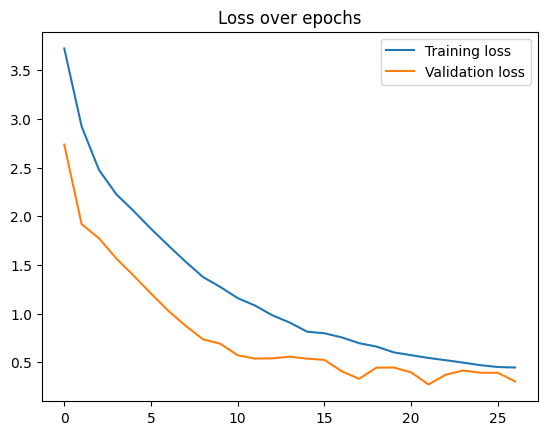

In [11]:
#Visualize Losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [12]:
# Calculate the Accuracy of the Model using test data

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 90.94%


In [13]:
#torch.save(model.state_dict(), "card_classifier93.96%.pth")

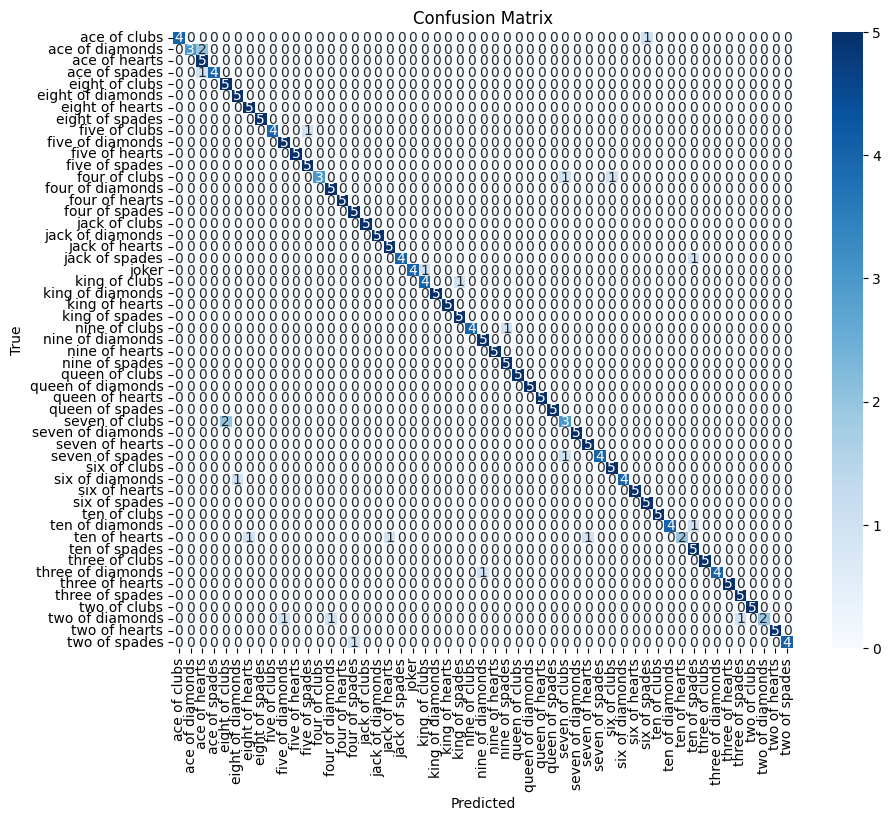

In [17]:
# Calculate predictions on test data
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()